In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


DEVICE = torch.device("cpu")   
print("Kullanılan cihaz:", DEVICE)

Kullanılan cihaz: cpu


In [14]:
DATA_DIR = "data"  
IMG_SIZE = 128
BATCH_SIZE = 32
NUM_CLASSES = 4

In [15]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    ])

In [16]:
train_ds = datasets.ImageFolder(root=f"{DATA_DIR}/train", transform=train_transform)
val_ds   = datasets.ImageFolder(root=f"{DATA_DIR}/val", transform=val_test_transform)
test_ds  = datasets.ImageFolder(root=f"{DATA_DIR}/test", transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
print("Sınıflar:", class_names)
print("Train/Val/Test örnek sayıları:", len(train_ds), len(val_ds), len(test_ds))

Sınıflar: ['Cloudy', 'Rainy', 'Shine', 'Sunrise']
Train/Val/Test örnek sayıları: 1127 1125 1128


In [17]:
class DeepBaseCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   

            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   

           
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   

            # Conv Bloğu 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  
        )

        # 256 kanal, 8x8 feature map (128x128'den 4 defa 2'ye bölündü)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepBaseCNN(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [18]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

In [19]:
EPOCHS = 20

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

Epoch 1/20 | Train Loss: 0.9399 Acc: 0.5670 | Val Loss: 0.7019 Acc: 0.7218
Epoch 2/20 | Train Loss: 0.6645 Acc: 0.7409 | Val Loss: 0.5649 Acc: 0.7822
Epoch 3/20 | Train Loss: 0.5418 Acc: 0.7879 | Val Loss: 0.5055 Acc: 0.7973
Epoch 4/20 | Train Loss: 0.5100 Acc: 0.8305 | Val Loss: 0.4770 Acc: 0.8000
Epoch 5/20 | Train Loss: 0.4438 Acc: 0.8367 | Val Loss: 0.3512 Acc: 0.8604
Epoch 6/20 | Train Loss: 0.3386 Acc: 0.8749 | Val Loss: 0.2384 Acc: 0.9164
Epoch 7/20 | Train Loss: 0.3029 Acc: 0.8900 | Val Loss: 0.3065 Acc: 0.8933
Epoch 8/20 | Train Loss: 0.2844 Acc: 0.9051 | Val Loss: 0.2166 Acc: 0.9236
Epoch 9/20 | Train Loss: 0.2565 Acc: 0.9130 | Val Loss: 0.2082 Acc: 0.9333
Epoch 10/20 | Train Loss: 0.2448 Acc: 0.9184 | Val Loss: 0.1407 Acc: 0.9502
Epoch 11/20 | Train Loss: 0.2446 Acc: 0.9130 | Val Loss: 0.1714 Acc: 0.9404
Epoch 14/20 | Train Loss: 0.1657 Acc: 0.9397 | Val Loss: 0.1212 Acc: 0.9618
Epoch 15/20 | Train Loss: 0.1768 Acc: 0.9406 | Val Loss: 0.0949 Acc: 0.9627
Epoch 16/20 | Train L

In [20]:
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, DEVICE)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Test Loss: 0.1220 | Test Acc: 0.9583


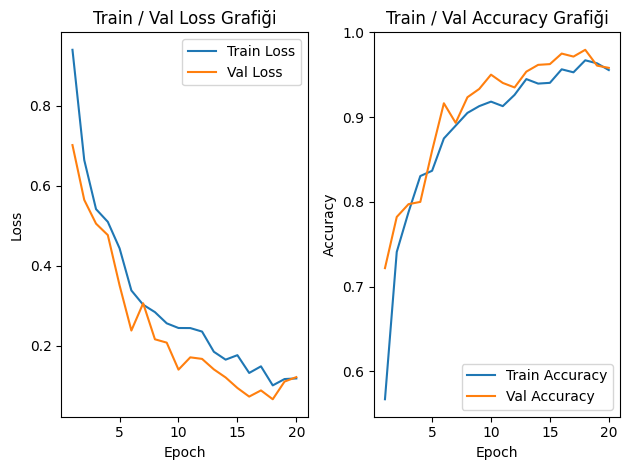

In [21]:
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train / Val Loss Grafiği")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_accs, label='Train Accuracy')
plt.plot(range(1, EPOCHS+1), val_accs, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train / Val Accuracy Grafiği")
plt.legend()

plt.tight_layout()
plt.show()

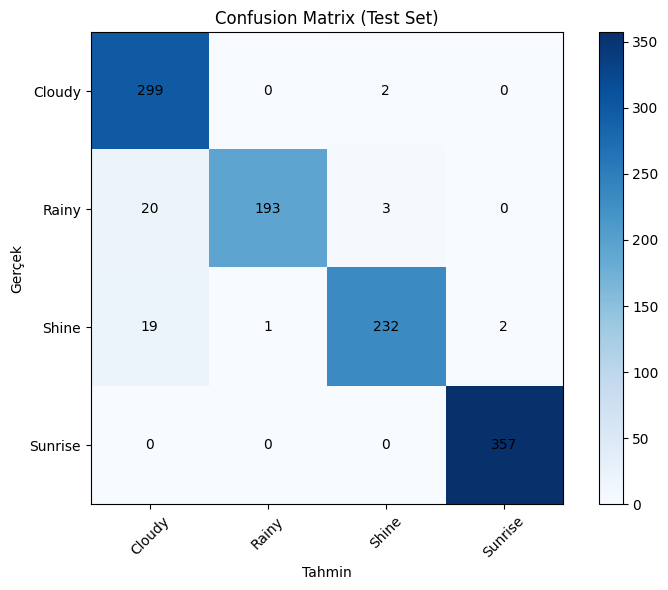


Sınıflandırma Raporu (Test Set):

              precision    recall  f1-score   support

      Cloudy       0.88      0.99      0.94       301
       Rainy       0.99      0.89      0.94       216
       Shine       0.98      0.91      0.95       254
     Sunrise       0.99      1.00      1.00       357

    accuracy                           0.96      1128
   macro avg       0.96      0.95      0.95      1128
weighted avg       0.96      0.96      0.96      1128



In [22]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()

tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)


for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center", color="black")

plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.tight_layout()
plt.show()

print("\nSınıflandırma Raporu (Test Set):\n")
print(classification_report(all_labels, all_preds, target_names=class_names))